<a href="https://colab.research.google.com/github/Shamitha22/5502Final_Project/blob/main/5502_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis of Social Media Posts for Brand Monitoring

In [ ]:
pip install tweepy


##Webscraping Tweets of Brands Using Twitter API

In [ ]:
import tweepy
import pandas as pd
import time

# Set your Twitter API v2 Bearer Token
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAN2J0wEAAAAAXwTamBnAlsERKECiF9IR%2BUZLYDE%3DJMdw3I8YKylc7xudfAXm1Wdfpf87NsqquroXlQeu2tZ9YcDn'

# Initialize client
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# List of brands to search for
brands = ["iPhone", "OnePlus", "Samsung", "Xiaomi"]

# Fetch tweets for each brand
tweet_data = []
for brand in brands:
    query = f"{brand} lang:en -is:retweet"  # Filter for English tweets and exclude retweets

    # Try fetching tweets and handle rate limit
    try:
        tweets = client.search_recent_tweets(query=query, max_results=20, tweet_fields=['created_at', 'text'])

        # Store tweets
        for tweet in tweets.data:
            tweet_data.append([brand, tweet.text, tweet.created_at])

        print(f"Fetched tweets for {brand}")

    except tweepy.TooManyRequests:
        print("Rate limit exceeded. Sleeping for 15 minutes...")
        time.sleep(900)  # Wait for 15 minutes before retrying

# Convert to DataFrame and save to CSV
if tweet_data:
    df = pd.DataFrame(tweet_data, columns=["Brand", "Tweet", "Date"])
    df.to_csv("tweets1.csv", index=False)
    print("Tweets collected and saved to 'tweets.csv'")
else:
    print("No tweets fetched.")


Fetched tweets for iPhone
Rate limit exceeded. Sleeping for 15 minutes...
Fetched tweets for Samsung
Rate limit exceeded. Sleeping for 15 minutes...
Fetched tweets for Xiaomi
Rate limit exceeded. Sleeping for 15 minutes...
Tweets collected and saved to 'tweets.csv'


##Data Preprocessing

In [ ]:
import re

# Load the tweets
df = pd.read_csv("tweets.csv")

# Clean the tweets
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)      # remove mentions
    text = re.sub(r"#\w+", "", text)      # remove hashtags
    text = re.sub(r"[^\w\s]", "", text)   # remove special characters
    text = text.lower().strip()
    return text

df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)

df.head()


,Brand,Tweet,Date,Cleaned_Tweet
0,iPhone,The world's simplest Bitcoin Lightning https:/...,2025-04-27 06:00:48+00:00,the worlds simplest bitcoin lightning the app...
1,iPhone,Good Morning from One-Ticket.\nShould you enco...,2025-04-27 06:00:38+00:00,good morning from oneticket\nshould you encoun...
2,iPhone,@mintgreenoshi iPhone！,2025-04-27 06:00:37+00:00,iphone
3,iPhone,"@BesuraTaansane @AshwiniVaishnaw Yes bhai, hop...",2025-04-27 06:00:27+00:00,yes bhai hopefully indians should get the ipho...
4,iPhone,#hourdle5645\nThe ANSWER was: PARER\navg tries...,2025-04-27 06:00:02+00:00,the answer was parer\navg tries 462\n8 out of ...


##Applying Bert-model

In [ ]:
!pip install transformers

from transformers import pipeline

# Load the sentiment-analysis pipeline (BERT Model)
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Classify the tweets
def classify_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return "Neutral"

    result = sentiment_pipeline(text[:512])[0]  # Handle max length 512
    label = result['label']
    score = result['score']

    if score < 0.55:
        return "Neutral"
    elif label == 'POSITIVE':
        return "Positive"
    else:
        return "Negative"

df['Sentiment'] = df['Cleaned_Tweet'].apply(classify_sentiment)

df.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


,Brand,Tweet,Date,Cleaned_Tweet,Sentiment
0,iPhone,The world's simplest Bitcoin Lightning https:/...,2025-04-27 06:00:48+00:00,the worlds simplest bitcoin lightning the app...,Negative
1,iPhone,Good Morning from One-Ticket.\nShould you enco...,2025-04-27 06:00:38+00:00,good morning from oneticket\nshould you encoun...,Positive
2,iPhone,@mintgreenoshi iPhone！,2025-04-27 06:00:37+00:00,iphone,Positive
3,iPhone,"@BesuraTaansane @AshwiniVaishnaw Yes bhai, hop...",2025-04-27 06:00:27+00:00,yes bhai hopefully indians should get the ipho...,Negative
4,iPhone,#hourdle5645\nThe ANSWER was: PARER\navg tries...,2025-04-27 06:00:02+00:00,the answer was parer\navg tries 462\n8 out of ...,Negative


##Trend Monitoring of Sentiment among different brands

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


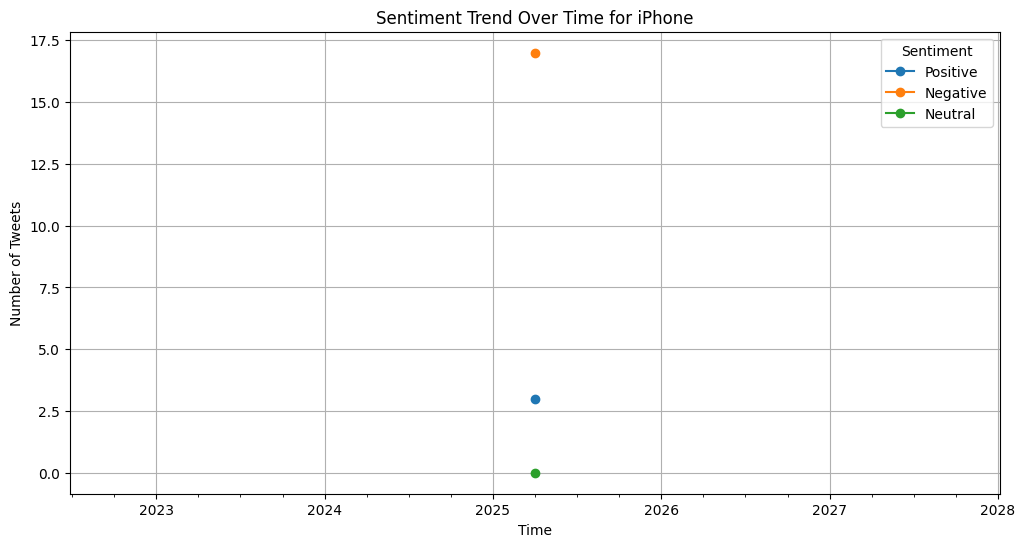

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


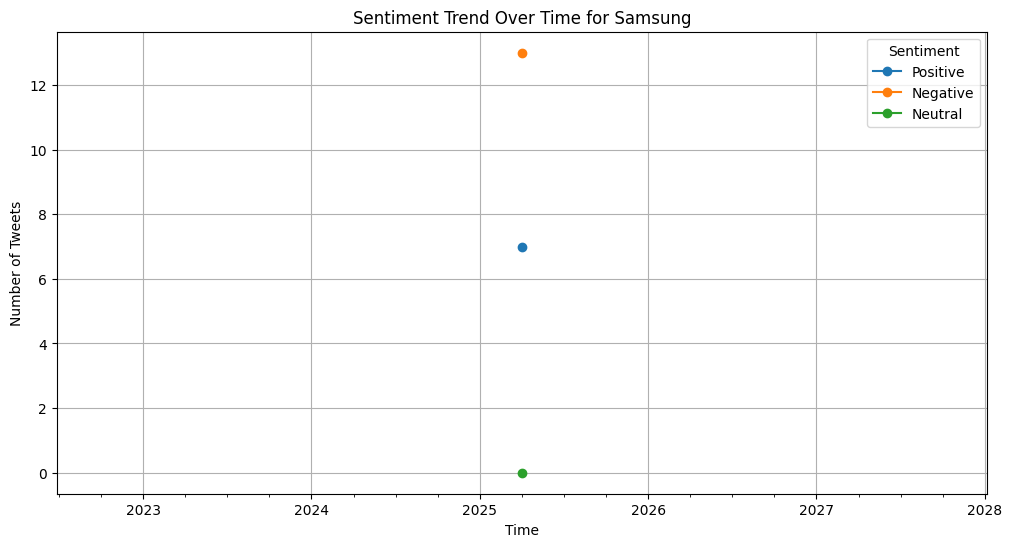

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


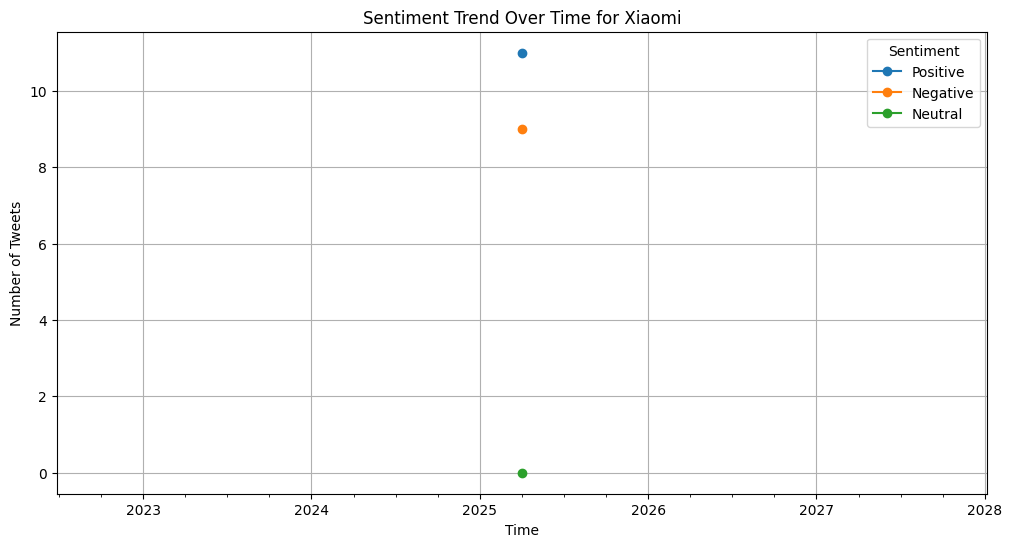

In [ ]:
# Fill missing sentiment columns
sentiment_trend = sentiment_trend.fillna(0)

# Make sure Positive, Negative, Neutral columns exist
for sentiment in ['Positive', 'Negative', 'Neutral']:
    if sentiment not in sentiment_trend.columns:
        sentiment_trend[sentiment] = 0

# Plot sentiment trend per brand
brands = df['Brand'].unique()

for brand in brands:
    brand_data = sentiment_trend[sentiment_trend['Brand'] == brand]
    brand_data.set_index('YearMonth')[['Positive', 'Negative', 'Neutral']].plot(kind='line', marker='o', figsize=(12,6))
    plt.title(f"Sentiment Trend Over Time for {brand}")
    plt.xlabel("Time")
    plt.ylabel("Number of Tweets")
    plt.grid(True)
    plt.legend(title='Sentiment')
    plt.show()


##Extra Unique Visualization Wordcloud for each brand showing positive, negative, and neutral

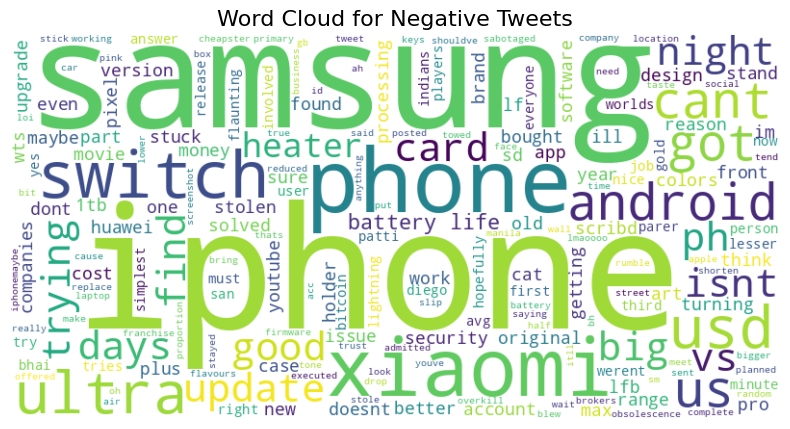

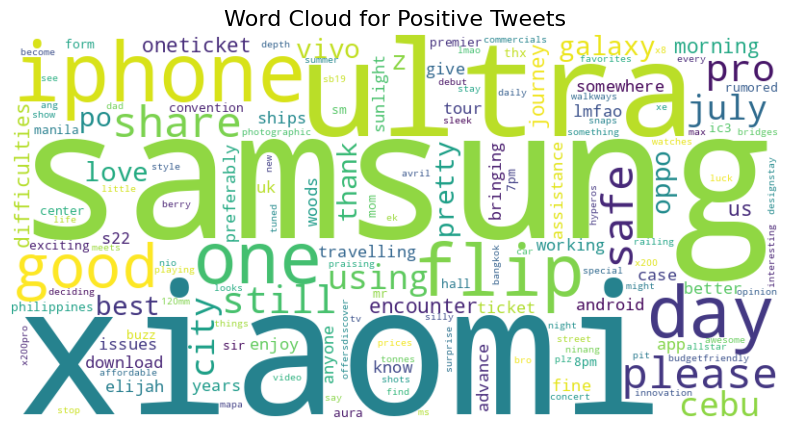

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentiments = df['Sentiment'].unique()

for sentiment in sentiments:
    text = " ".join(df[df['Sentiment'] == sentiment]['Cleaned_Tweet'])

    if text.strip():  # Check if text is not empty
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {sentiment} Tweets", fontsize=16)
        plt.show()
    else:
        print(f"Skipping WordCloud for '{sentiment}' — no tweets available.")


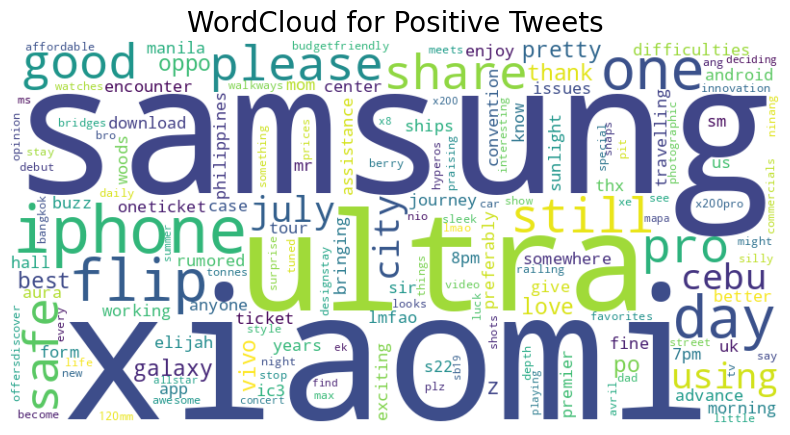

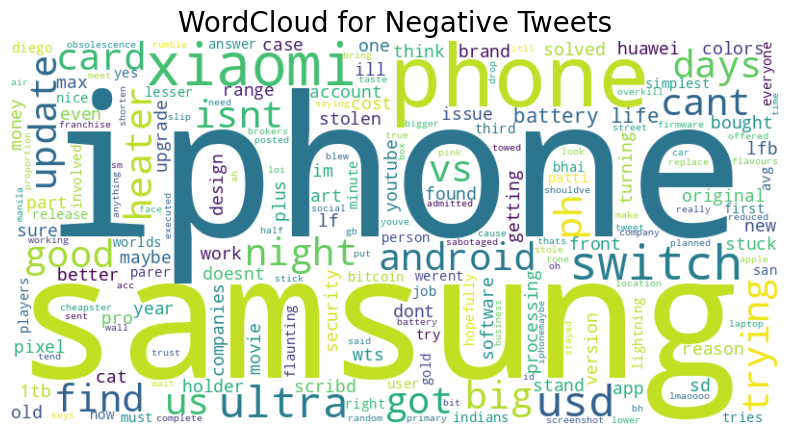

No tweets for Neutral, skipping wordcloud.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df and it has 'Sentiment' and 'Cleaned_Tweet' columns

# For each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    # Join all cleaned tweets for that sentiment
    text = " ".join(df[df['Sentiment'] == sentiment]['Cleaned_Tweet'])

    if text.strip() == "":
        print(f"No tweets for {sentiment}, skipping wordcloud.")
        continue  # Skip if no text

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the WordCloud
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {sentiment} Tweets", fontsize=20)
    plt.show()


##Model Evaluation

In [ ]:
from transformers import pipeline

# Load the sentiment-analysis pipeline (BERT Model)
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to classify the sentiment
def classify_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return "Neutral"  # Handle empty or null text
    result = sentiment_pipeline(text[:512])[0]  # Handle max length 512
    label = result['label']
    score = result['score']

    # Classify as Positive/Negative/Neutral
    if score < 0.55:
        return "Neutral"
    elif label == 'POSITIVE':
        return "Positive"
    else:
        return "Negative"

# Apply the function to create the 'Sentiment' column
df['Sentiment'] = df['Tweet'].apply(classify_sentiment)

# View the updated DataFrame
print(df[['Tweet', 'Sentiment']].head())


Device set to use cpu


                                               Tweet Sentiment
0  The world's simplest Bitcoin Lightning https:/...  Negative
1  Good Morning from One-Ticket.\nShould you enco...  Positive
2                             @mintgreenoshi iPhone！  Negative
3  @BesuraTaansane @AshwiniVaishnaw Yes bhai, hop...  Negative
4  #hourdle5645\nThe ANSWER was: PARER\navg tries...  Negative


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example of manual labels (replace this with your actual manually labeled data)
# Manually label a subset of 60 tweets for comparison. The list should match the number of predictions.
manual_labels = ["Negative", "Positive", "Negative", "Negative", "Negative", "Negative", "Neutral"]  # Example (replace with actual labels)

# BERT predictions on the same subset (make sure these match the manually labeled data)
bert_predictions = df['Sentiment'].head(len(manual_labels)).values  # Take first N values of predicted sentiment

# Calculate performance metrics
accuracy = accuracy_score(manual_labels, bert_predictions)
precision = precision_score(manual_labels, bert_predictions, average='weighted')
recall = recall_score(manual_labels, bert_predictions, average='weighted')
f1 = f1_score(manual_labels, bert_predictions, average='weighted')

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.8571
Precision: 0.7381
Recall: 0.8571
F1-Score: 0.7922


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt

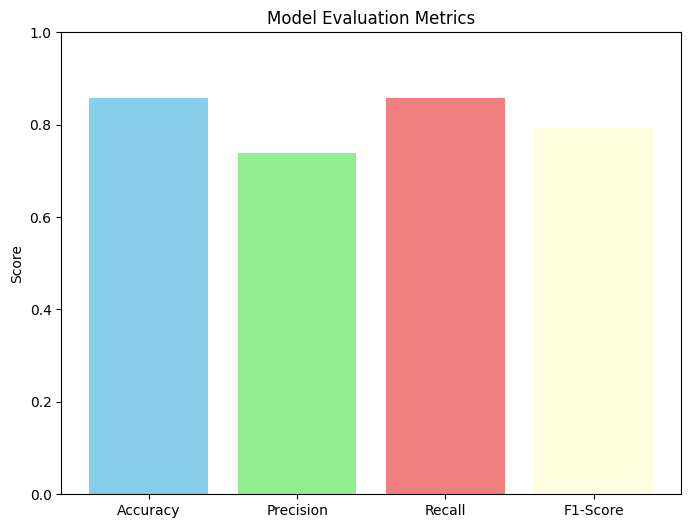

In [ ]:
import matplotlib.pyplot as plt

# Given evaluation metrics
accuracy = 0.8571
precision = 0.7381
recall = 0.8571
f1_score = 0.7922

# Metrics list
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy, precision, recall, f1_score]

# Plotting the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Setting the range for y-axis from 0 to 1 (0% to 100%)
plt.show()


##Using Twitter API Webscraping the data of Iphone

In [ ]:
import tweepy
import pandas as pd

# Set your Twitter API v2 Bearer Token
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAPWH0wEAAAAAHIlRCjk74uW%2BCaXF9AljYdHFtpE%3DAcjlMEOw75pBTHxPLPJJRBWcTeEzSZd84o84kCqDaKWBeRWo'

# Authentication using Client (API v2)
client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Search for recent tweets mentioning "iPhone"
query = "iPhone lang:en -is:retweet"   # 'lang:en' to filter English tweets, '-is:retweet' to avoid retweets
tweets = client.search_recent_tweets(query=query, max_results=100, tweet_fields=['created_at', 'text'])

# Store tweets in a list
tweet_data = []
for tweet in tweets.data:
    tweet_data.append([tweet.text, tweet.created_at])

# Convert to DataFrame and save to CSV
df = pd.DataFrame(tweet_data, columns=["Tweet", "Date"])
df.to_csv("tweets.csv", index=False)
print("Tweets collected and saved to 'tweets.csv'")


Tweets collected and saved to 'tweets.csv'


In [ ]:
import pandas as pd

# Load your existing tweets and sentiments data
df = pd.read_csv('tweets.csv')

# List of brands to monitor
brands_list = ['iPhone', 'Apple', 'Samsung', 'Google', 'Huawei', 'Sony']

# Function to check if a brand is mentioned in the tweet
def extract_brand(tweet):
    for brand in brands_list:
        if brand.lower() in tweet.lower():
            return brand
    return 'Other'  # In case no brand is mentioned

# Apply the function to create a new column 'Brand'
df['Brand'] = df['Tweet'].apply(extract_brand)

# Check if the 'Brand' column is added
df.head()


,Tweet,Date,Brand
0,💸 MASSIVE SAVINGS + COUPON:\nfor Magsafe Batte...,2025-04-27 00:53:00+00:00,iPhone
1,@CNBC China will likely retain manufacturing d...,2025-04-27 00:52:59+00:00,iPhone
2,Why there is no @goodreads app widget on iphon...,2025-04-27 00:52:58+00:00,iPhone
3,@YinZP365 so are you saying india will benefit...,2025-04-27 00:52:02+00:00,iPhone
4,Recorded TV broadcast slomo with a \n iphone o...,2025-04-27 00:51:28+00:00,iPhone


##Brand Mentions of iphone

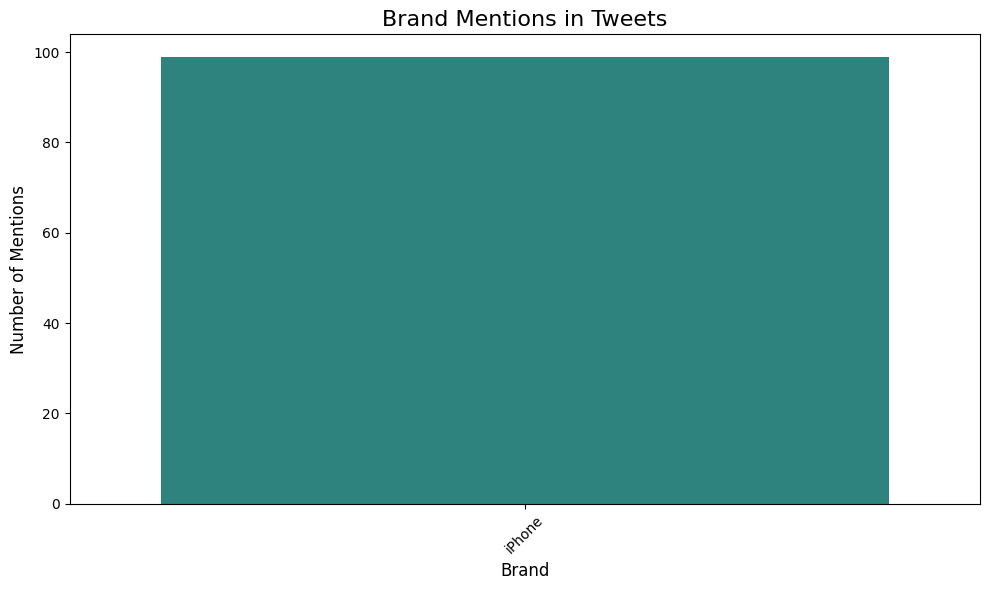

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each brand
brand_counts = df['Brand'].value_counts()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='viridis')

# Customize the plot
plt.title('Brand Mentions in Tweets', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
pip install nltk


#Code for Brand Monitoring with Offline Sentiment Analysis

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from transformers import pipeline

# Download stopwords if not installed
import nltk
nltk.download('stopwords')

# Set of stopwords for cleaning
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters & digits
    text = text.lower()  # Convert text to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Load the pre-trained model (offline) for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to classify sentiment (positive, negative, neutral)
def classify_sentiment(text, brand_name="nike"):
    # Check if brand name is mentioned
    if brand_name.lower() in text:
        result = sentiment_pipeline(text)[0]
        sentiment_label = result['label']
        sentiment_score = result['score']

        # If score is below threshold, classify as neutral
        if sentiment_score < 0.55:
            return "Neutral"
        return sentiment_label
    return None  # Return None if brand is not mentioned

# Load the dataset (Assuming you have a column 'Tweet' with the tweet texts)
df = pd.read_csv("tweets.csv")

# Clean the tweets
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)

# Apply sentiment analysis to the cleaned tweets (only brand-related)
brand_name = "nike"  # Specify the brand you are monitoring
df['Sentiment'] = df['Cleaned_Tweet'].apply(lambda x: classify_sentiment(x, brand_name))

# Only keep rows with brand-related sentiment
df_brand_tweets = df[df['Sentiment'].notna()]

# Save sentiment analysis results to a CSV
df_brand_tweets.to_csv("sentiment_analysis_result.csv", index=False)
print(f"Sentiment analysis completed and saved to 'sentiment_analysis_result.csv'")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Sentiment analysis completed and saved to 'sentiment_analysis_result.csv'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Device set to use cpu


Sentiment analysis for 'iPhone' completed and saved to 'sentiment_analysis_result_iphone.csv'


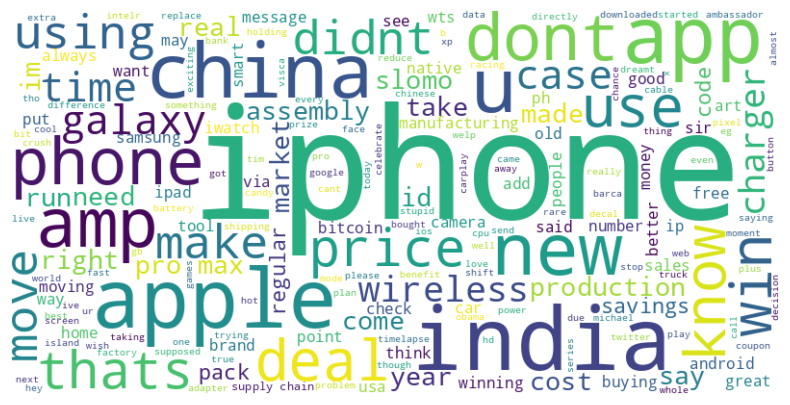

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from transformers import pipeline
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download stopwords if not installed
nltk.download('stopwords')

# Set of stopwords for cleaning
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters & digits
    text = text.lower()  # Convert text to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Load the pre-trained model (offline) for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to classify sentiment (positive, negative, neutral)
def classify_sentiment(text, brand_name="iphone"):
    # Check if brand name is mentioned
    if brand_name.lower() in text:
        result = sentiment_pipeline(text)[0]
        sentiment_label = result['label']
        sentiment_score = result['score']

        # If score is below threshold, classify as neutral
        if sentiment_score < 0.55:
            return "Neutral"
        return sentiment_label
    return None  # Return None if brand is not mentioned

# Load the dataset (Assuming you have a column 'Tweet' with the tweet texts)
df = pd.read_csv("tweets.csv")

# Clean the tweets
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)

# Apply sentiment analysis to the cleaned tweets (only brand-related)
brand_name = "iphone"  # Specify the brand you are monitoring (set to "iphone" here)
df['Sentiment'] = df['Cleaned_Tweet'].apply(lambda x: classify_sentiment(x, brand_name))

# Only keep rows with brand-related sentiment
df_brand_tweets = df[df['Sentiment'].notna()]

# Save sentiment analysis results to a CSV
df_brand_tweets.to_csv("sentiment_analysis_result_iphone.csv", index=False)
print(f"Sentiment analysis for 'iPhone' completed and saved to 'sentiment_analysis_result_iphone.csv'")

# Generate word cloud for cleaned tweets
text_for_wordcloud = ' '.join(df_brand_tweets['Cleaned_Tweet'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Don't show axes for the word cloud
plt.show()


#Text Cleaning Function

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not installed
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function to clean text: remove URLs, mentions, hashtags, special characters
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and digits
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply cleaning function to the tweets
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pip install transformers


#Sentiment Analysis Using Hugging Face's BERT

In [ ]:
from transformers import pipeline

# Load pre-trained BERT model for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to classify sentiment: positive, negative, or neutral
def classify_sentiment(text):
    result = sentiment_pipeline(text)[0]
    sentiment_label = result['label']
    sentiment_score = result['score']

    # Classify as neutral if score is below threshold
    if sentiment_score < 0.55:
        return "Neutral"
    return sentiment_label

# Apply sentiment classification
df['Sentiment'] = df['Cleaned_Tweet'].apply(classify_sentiment)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [ ]:
from transformers import pipeline

# Load pre-trained BERT model for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")

# Apply sentiment analysis to cleaned tweets
df['Sentiment'] = df['Cleaned_Tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Save the final results to CSV
df.to_csv("sentiment_analysis_result.csv", index=False)
print("Sentiment analysis completed and saved to 'sentiment_analysis_result.csv'")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Sentiment analysis completed and saved to 'sentiment_analysis_result.csv'


#Topic Modeling Using BERTopic

In [ ]:
from bertopic import BERTopic

# Initialize BERTopic model
topic_model = BERTopic()

# Fit the model on the cleaned tweets (assumes 'Cleaned_Tweet' column exists in df)
topics, probs = topic_model.fit_transform(df['Cleaned_Tweet'])

# Add topics to DataFrame
df['Topic'] = topics


In [ ]:
# Save the resulting DataFrame with sentiment and topics to CSV
df.to_csv("tweets_with_topics_and_sentiment.csv", index=False)
print("Sentiment analysis and topic modeling completed and saved.")


Sentiment analysis and topic modeling completed and saved.


In [ ]:
# Filter top tweets by positive sentiment
top_positive_tweets = df[df['Sentiment'] == 'POSITIVE'].sort_values(by='Date', ascending=False)

# Display top positive tweets
print("Top Positive Tweets:")
print(top_positive_tweets[['Tweet', 'Sentiment', 'Date']].head(10))  # Display top 10 tweets

# Optionally, you can also display top negative or neutral tweets:
top_negative_tweets = df[df['Sentiment'] == 'NEGATIVE'].sort_values(by='Date', ascending=False)
print("\nTop Negative Tweets:")
print(top_negative_tweets[['Tweet', 'Sentiment', 'Date']].head(10))  # Display top 10 tweets


Top Positive Tweets:
                                                Tweet Sentiment  \
1   @CNBC China will likely retain manufacturing d...  POSITIVE   
2   Why there is no @goodreads app widget on iphon...  POSITIVE   
3   @YinZP365 so are you saying india will benefit...  POSITIVE   
10  WIN an Apple iPhone 16 Pro Max + Cygnett wirel...  POSITIVE   
12  @LeakerApple It looks cool. A thousand times b...  POSITIVE   
13  @Zlatan_Ibile @Zlatan_Ibile great win my boss ...  POSITIVE   
14  @RetroAgent12 iPhone from China to... India! N...  POSITIVE   
15  @jaehmrk it’s rlly good 😭 omg the iphone 7-8 h...  POSITIVE   
16  YEYYY!!!! HELLOO IPHONE 16 PLUS HUHUHUHUHH I L...  POSITIVE   
19  Apple plans to produce all US-sold iPhones in ...  POSITIVE   

                         Date  
1   2025-04-27 00:52:59+00:00  
2   2025-04-27 00:52:58+00:00  
3   2025-04-27 00:52:02+00:00  
10  2025-04-27 00:50:39+00:00  
12  2025-04-27 00:50:29+00:00  
13  2025-04-27 00:50:25+00:00  
14  2025-04-27 00

#Visualization: Sentiment Distribution

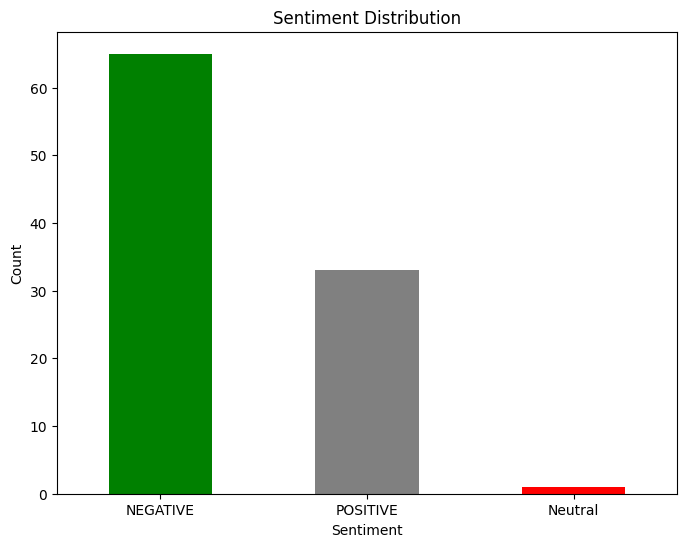

In [ ]:
import matplotlib.pyplot as plt

# Plot sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


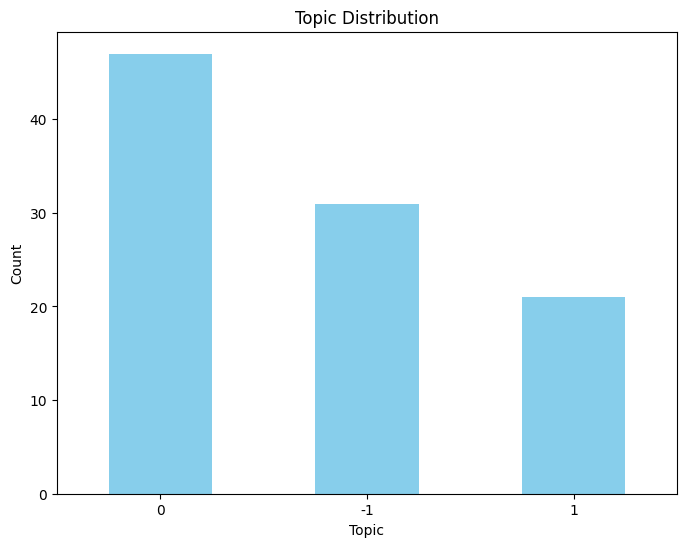

In [ ]:
# Plot topic distribution
topic_counts = df['Topic'].value_counts()

plt.figure(figsize=(8, 6))
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [ ]:
!pip install psycopg2-binary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.4 MB/s eta 0:00:00


##Using Postgre SQL Google console to store the data in database
------

In [ ]:
import psycopg2
import pandas as pd

# Connect to your PostgreSQL database (replace with your connection details)
conn = psycopg2.connect(dbname="5502FinalProject",password="***********", host="hsuhugdu",port="5432")

# Create a cursor object
cur = conn.cursor()

# Load your DataFrame containing tweets and sentiments
df = pd.read_csv('tweets.csv')

# Insert data into PostgreSQL table
for _, row in df.iterrows():
    cur.execute(
        "INSERT INTO tweets (tweet, sentiment, brand, created_at) VALUES (%s, %s, %s, %s)",
        (row['Tweet'], row['Sentiment'], row['Brand'], row['Date'])
    )

# Commit the transaction and close the cursor and connection
conn.commit()
cur.close()
conn.close()

print("Data inserted into PostgreSQL database successfully.")


##Trend Monitoring on iphone

---



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Device set to use cpu


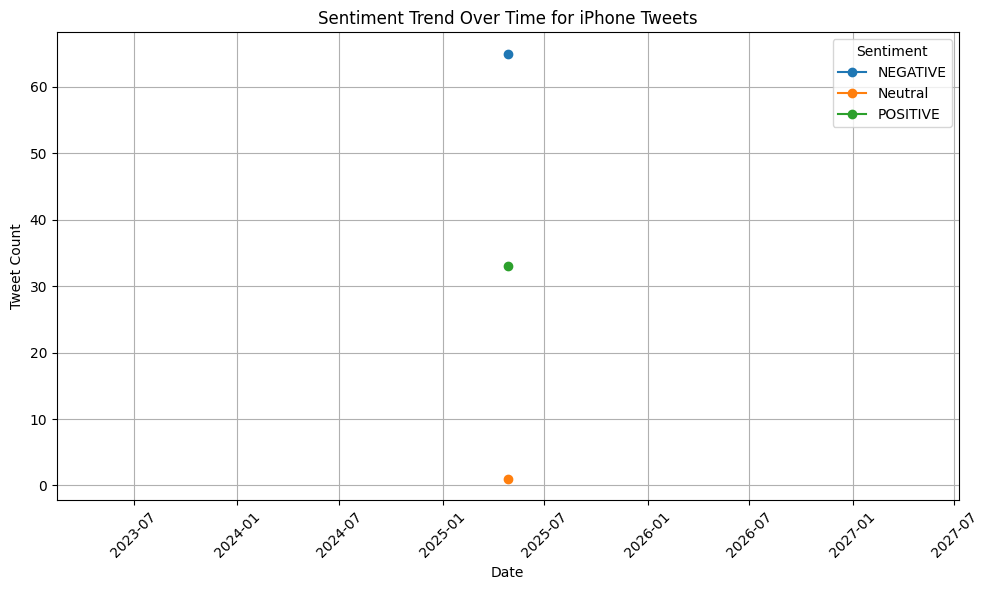

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from transformers import pipeline
import nltk
import matplotlib.pyplot as plt

# Download stopwords if not installed
nltk.download('stopwords')

# Set of stopwords for cleaning
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters & digits
    text = text.lower()  # Convert text to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Load the pre-trained model (offline) for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to classify sentiment (positive, negative, neutral)
def classify_sentiment(text, brand_name="iphone"):
    # Check if brand name is mentioned
    if brand_name.lower() in text:
        result = sentiment_pipeline(text)[0]
        sentiment_label = result['label']
        sentiment_score = result['score']

        # If score is below threshold, classify as neutral
        if sentiment_score < 0.55:
            return "Neutral"
        return sentiment_label
    return None  # Return None if brand is not mentioned

# Load the dataset (Assuming you have a column 'Tweet' with the tweet texts)
df = pd.read_csv("tweets.csv")

# Clean the tweets
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)

# Apply sentiment analysis to the cleaned tweets (only brand-related)
brand_name = "iphone"  # Specify the brand you are monitoring (set to "iphone" here)
df['Sentiment'] = df['Cleaned_Tweet'].apply(lambda x: classify_sentiment(x, brand_name))

# Only keep rows with brand-related sentiment
df_brand_tweets = df[df['Sentiment'].notna()]

# Convert the 'created_at' column to datetime (assuming it's in string format)
df_brand_tweets['Date'] = pd.to_datetime(df_brand_tweets['Date'])

# Group by date and count sentiment occurrences
sentiment_trend = df_brand_tweets.groupby([df_brand_tweets['Date'].dt.date, 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trend over time
sentiment_trend.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Sentiment Trend Over Time for iPhone Tweets')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00


In [3]:
import gradio as gr
from transformers import pipeline

# Load the sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Define prediction function
def predict_sentiment(text):
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    score = result['score']
    return f"Sentiment: {label} (Confidence: {score:.2f})"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter a tweet here..."),
    outputs="text",
    title="Tweet Sentiment Analysis",
    description="Enter a tweet and get its predicted sentiment!"
)

# Launch the interface
iface.launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://864a70bd06a5ffbd31.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
!pip install flask-ngrok


In [20]:
!ngrok config add-authtoken $YOUR_AUTHTOKEN

ERROR:  accepts 1 arg(s), received 0


In [29]:
# Import libraries
from flask import Flask, request, render_template_string
from pyngrok import ngrok
import pandas as pd
from transformers import pipeline

# Set your ngrok token
ngrok.set_auth_token("")

# Load BERT Sentiment Model
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Load your tweet1.csv
df = pd.read_csv('tweets1.csv')

# Define a function to classify sentiments
def classify_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return "Neutral"
    result = sentiment_pipeline(text[:512])[0]  # Limit text length
    label = result['label']
    score = result['score']
    if score < 0.55:
        return "Neutral"
    elif label == 'POSITIVE':
        return "Positive"
    else:
        return "Negative"

# Classify sentiments for all tweets
df['Sentiment'] = df['Tweet'].apply(classify_sentiment)

# Flask app
app = Flask(__name__)

# Basic HTML Template
html = """
<!DOCTYPE html>
<html>
<head>
    <title>Tweet Sentiment Analyzer</title>
</head>
<body style="text-align: center; font-family: Arial, sans-serif;">
    <h1>Tweet Sentiment Analyzer</h1>
    <form method="post">
        <textarea name="tweet" rows="4" cols="50" placeholder="Enter your tweet here"></textarea><br><br>
        <input type="submit" value="Analyze">
    </form>
    {% if sentiment %}
        <h2>Sentiment: {{ sentiment }}</h2>
    {% endif %}
</body>
</html>
"""

# Routes
@app.route("/", methods=["GET", "POST"])
def home():
    sentiment = None
    if request.method == "POST":
        tweet = request.form["tweet"]
        sentiment = classify_sentiment(tweet)
    return render_template_string(html, sentiment=sentiment)

# Run the app
if __name__ == "__main__":
    # Open an ngrok tunnel to the app
    public_url = ngrok.connect(5000)
    print("Public URL:", public_url)

    # Start Flask server
    app.run(port=5000)


Device set to use cpu


Public URL: NgrokTunnel: "https://63ed-34-83-227-148.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [27/Apr/2025 22:53:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Apr/2025 22:53:40] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Apr/2025 22:54:28] "POST / HTTP/1.1" 200 -
